## imports

In [1]:
import lenstronomy

lenstronomy.__version__

'1.9.3'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import seaborn as sns

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [3]:
gc.collect()

21

## load model chains and pre-computed velocity dispersion

In [4]:
import sys
sys.path.insert(0, './process_output')

from output_class import *

In [5]:
dir_prefix = '../temp/'
dir_suffix = '_out.txt'

save_fig = True # if True, will overwrite figures in the paper

In [6]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run145_0_0_1_0_0_shortened',
    '2038_run145_0_0_2_0_0_shortened',
    '2038_run145_0_1_0_0_0_shortened',
    '2038_run145_0_1_1_0_0_shortened',
    '2038_run145_0_1_2_0_0_shortened',
    
    '2038_run146_0_0_0_0_0_shortened',
    '2038_run146_0_0_1_0_0_shortened',
    '2038_run146_0_0_2_0_0_shortened',
    '2038_run146_0_1_0_0_0_shortened',
    '2038_run146_0_1_1_0_0_shortened',
    '2038_run146_0_1_2_0_0_shortened',
]

In [7]:
powerlaw_models = []
powerlaw_models_optical_vel_dis = []
powerlaw_models_optical_vel_dis_20percent_reff = []

# create model output instances
for files, models, dir_string in zip([powerlaw_files, powerlaw_files, powerlaw_files],
                         [powerlaw_models, powerlaw_models_optical_vel_dis, powerlaw_models_optical_vel_dis_20percent_reff],
                         ['vel_dis_ir', 'vel_dis_optical', 'vel_dis_optical_20p']
                        ):
    for model_id in files: #[-2:]:
        models.append(ModelOutput(model_id, "powerlaw", dir_prefix, dir_suffix, is_test=False))
    
    for i, model in enumerate(models):
    #     model.load_velocity_dispersion(model.model_id, '../../../vel_dis/vd_', dir_suffix, 1000)
    #     model.load_a_ani(model.model_id, '../../../vel_dis/aani_', dir_suffix, 1000)
    #     model.load_r_eff(model.model_id, '../../../vel_dis/reff_', dir_suffix, 1000)

        model.load_velocity_dispersion(model.model_id, '../{}/vd_'.format(dir_string), dir_suffix, 1000)
        model.load_a_ani(model.model_id, '../{}/aani_'.format(dir_string), dir_suffix, 1000)
        model.load_r_eff(model.model_id, '../{}/reff_'.format(dir_string), dir_suffix, 1000)

### compute/load model time-delays

In [8]:
for model in powerlaw_models:
    #model.compute_model_time_delays()
    #model.save_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    model.load_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    #break
    
for model in powerlaw_models_optical_vel_dis:
    #model.compute_model_time_delays()
    #model.save_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    model.load_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    #break
    
for model in powerlaw_models_optical_vel_dis_20percent_reff:
    #model.compute_model_time_delays()
    #model.save_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    model.load_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    #break

### plot velocity dispersions

In [9]:
from getdist import plots
from getdist import MCSamples

In [10]:
powerlaw_bics = [model.bic for model in powerlaw_models]
#composite_bics = [model.bic for model in composite_models]

In [11]:
# From the notebook "Fermat potentials and lens model comparisons"
sigma_numeric_bic, sigma_model_bic = 69, 304

Total velocity dispersion samples: (3, 39573)
Removed no burn in
Total velocity dispersion samples: (3, 39573)
Removed no burn in
Total velocity dispersion samples: (3, 39573)
Removed no burn in


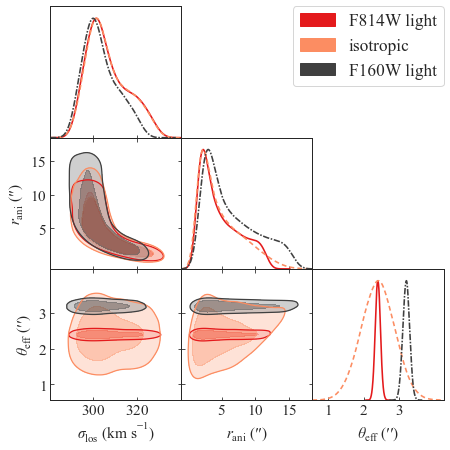

In [14]:
all_velocity_dispersion_samples = []

pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)

for i, models in enumerate([powerlaw_models, powerlaw_models_optical_vel_dis, powerlaw_models_optical_vel_dis_20percent_reff]):
    for k, model in enumerate(models):

        num_sample = int(pl_weights[k] * model.get_num_samples())


        vel_dis_samples = np.array([model.model_velocity_dispersion,
                               model.a_ani * model.r_eff,
                               model.r_eff
                            ])
        if k == 0:
            all_vel_dis_samples = vel_dis_samples[:, :num_sample]
        else:
            all_vel_dis_samples = np.append(all_vel_dis_samples, vel_dis_samples[:, :num_sample], axis=1)

    
    if i == 0:
        mean_vel_dis = np.mean(all_vel_dis_samples[0])
    
    # blinding predicted velocity dispersion
    #all_vel_dis_samples[0] = all_vel_dis_samples[0]/mean_vel_dis - 1.


    print('Total velocity dispersion samples: {}'.format(all_vel_dis_samples.shape))


    velocity_dispersion_samples = MCSamples(samples=all_vel_dis_samples.T, 
                                   names=[
                                          'sigma', 'a_ani', 'r_eff',
                                         ], 
                                  labels=[
                                          '\\sigma_{\\rm los}\\ ({\\rm km \\ s^{-1}})', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                          'r_{\\rm ani}\ ({\prime\prime})',
                                          '\\theta_{\\rm eff}\ ({\prime\prime})',
                                         ],
                      )
    velocity_dispersion_samples.updateSettings({'smooth_scale_2D': 0.3})
    velocity_dispersion_samples.updateSettings({'smooth_scale_1D': 0.3})
    
    
    all_velocity_dispersion_samples.append(velocity_dispersion_samples)
    
    

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 2.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 18

g.settings.legend_fontsize = 20
# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4

colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([all_velocity_dispersion_samples[1], all_velocity_dispersion_samples[2], all_velocity_dispersion_samples[0]],
                 #legend_labels=['F814W light', r'20% $R_{\rm eff}$ uncertainty', 'F160W light'],
                legend_labels=['F814W light', r'isotropic', 'F160W light'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6, 1.6], 
                 contour_ls=['-', '--', '-.'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=[colors[0], pf.cb2_orange, pf.cb_grey],
                 param_limits={'dphi_AB': (-0.6, 0.7), 'dphi_AD': (-0.6, 0.7), 'dphi_BD': (-0.6, 0.7), 
                               'lambda_int': (0.3, 3), #'a_ani': (0.5, 5.)
                              },
                 #fontsize=100
               )

#g.fig.tight_layout()
if save_fig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/kinematics_systematic_compare.pdf', bbox_inches='tight')
    
#g.fig

### load Pantheon $D_{\rm s}/D_{\rm  ds}$

In [13]:
pantheon_Dsds = np.loadtxt('Pantheon_D_sds_distribution.txt')

sns.kdeplot(pantheon_Dsds)
plt.xlabel(r'$D_{\rm s}/D_{\rm ds}$')
plt.ylabel('Probability density');

In [14]:
fiducial_cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

z_s = 0.777
z_l = 0.230

fiducial_Dsds = fiducial_cosmo.angular_diameter_distance(z_s).value / fiducial_cosmo.angular_diameter_distance_z1z2(z_l, z_s).value

fiducial_Dsds

1.5201658806267908

## Load external convergence

In [15]:
from scipy.interpolate import interp1d


def approx_cdf_1d(x_array, pdf_array):
    """
    Copied from lenstronomy v0.9.2.
    :param x_array: x-values of pdf
    :param pdf_array: pdf array of given x-values
    """
    norm_pdf = pdf_array/np.sum(pdf_array)
    cdf_array = np.zeros_like(norm_pdf)
    cdf_array[0] = norm_pdf[0]
    for i in range(1, len(norm_pdf)):
        cdf_array[i] = cdf_array[i-1] + norm_pdf[i]
    cdf_func = interp1d(x_array, cdf_array)
    cdf_inv_func = interp1d(cdf_array, x_array)
    return cdf_array, cdf_func, cdf_inv_func


class Approx(object):
    """
    Class for approximations with a given pdf sample.
    Copied from lenstronomy v0.9.2.
    """
    def __init__(self, x_array, pdf_array):
        self._cdf_array, self._cdf_func, self._cdf_inv_func = approx_cdf_1d(x_array, pdf_array)

    def draw(self, n=1):
        """

        :return:
        """
        p = np.random.uniform(0, 1, n)
        return self._cdf_inv_func(p)

    @property
    def draw_one(self):
        """

        :return:
        """
        return self.draw(n=1)

### power-law

In [16]:
kappa_pl_file = '../data/gammaanowarpowkappahist_2038_measured_3innermask_nobeta_removehandpicked_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_22.5_med_increments2_2_2_emptymsk_shearwithoutprior.cat'

kappa_pl = np.loadtxt(kappa_pl_file)
print('Number of kappa bins:',  len(kappa_pl))

kappa_list = np.linspace(-0.2+0.0003, 1-0.0003, len(kappa_pl))

pdf_list_pl = kappa_pl

pdf_approx_pl = Approx(kappa_list, pdf_list_pl)

pdf_draw_pl = pdf_approx_pl.draw(n=50000)

#plt.hist(pdf_draw, bins=np.linspace(-0.1, 0.2, 100))
sns.distplot(pdf_draw_pl)
plt.title('Test draws for power-law')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

print('Sampled kappa -> median: {:.3f}, mean: {:.3f}, std: {:.3f}'.format(np.median(pdf_draw_pl), np.mean(pdf_draw_pl), np.std(pdf_draw_pl)))

plt.plot(kappa_list, kappa_pl)
plt.title('Original power-law')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

mean_kappa_pl = np.sum(kappa_list*kappa_pl) / np.sum(kappa_pl)
print('Mean kappa from bins: {:.3f}'.format(mean_kappa_pl))

def draw_kappa_pl(n=1):
    return pdf_approx_pl.draw(n=n)

Number of kappa bins: 2000
Sampled kappa -> median: 0.058, mean: 0.067, std: 0.042
Mean kappa from bins: 0.068


/Users/ajshajib/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


## Time-delay predictions assuming $\lambda_{\rm int} = 1$

In [17]:
model.model_velocity_dispersion.shape

powerlaw_kinematics_likelihood = []
powerlaw_kinematics_likelihood_optical_vel_dis = []
powerlaw_kinematics_likelihood_optical_vel_dis_20percent_reff = []



def get_kinematics_likelihood(model):
    """
    Get lambda_int distribution from model predicted velocity dispersion.
    """
    log_likelihood = -0.5 * (model.model_velocity_dispersion * np.sqrt(1 - model.kappa_ext) -  model.VEL_DIS[0])**2 / model.SIG_VEL_DIS[0]**2
    
    return np.exp(log_likelihood)
    
for model in powerlaw_models:                                               
    model.kappa_ext = draw_kappa_pl(n=model.model_velocity_dispersion.shape)
    powerlaw_kinematics_likelihood.append(get_kinematics_likelihood(model))
    
    
for model in powerlaw_models_optical_vel_dis:                                               
    model.kappa_ext = draw_kappa_pl(n=model.model_velocity_dispersion.shape)
    powerlaw_kinematics_likelihood_optical_vel_dis.append(get_kinematics_likelihood(model))

for model in powerlaw_models_optical_vel_dis_20percent_reff:                                               
    model.kappa_ext = draw_kappa_pl(n=model.model_velocity_dispersion.shape)
    powerlaw_kinematics_likelihood_optical_vel_dis_20percent_reff.append(get_kinematics_likelihood(model))


Power-law samples importance sampled: (5, 3971)
Removed no burn in
Power-law samples importance sampled: (5, 3971)
Removed no burn in
Power-law samples importance sampled: (5, 3971)
Removed no burn in


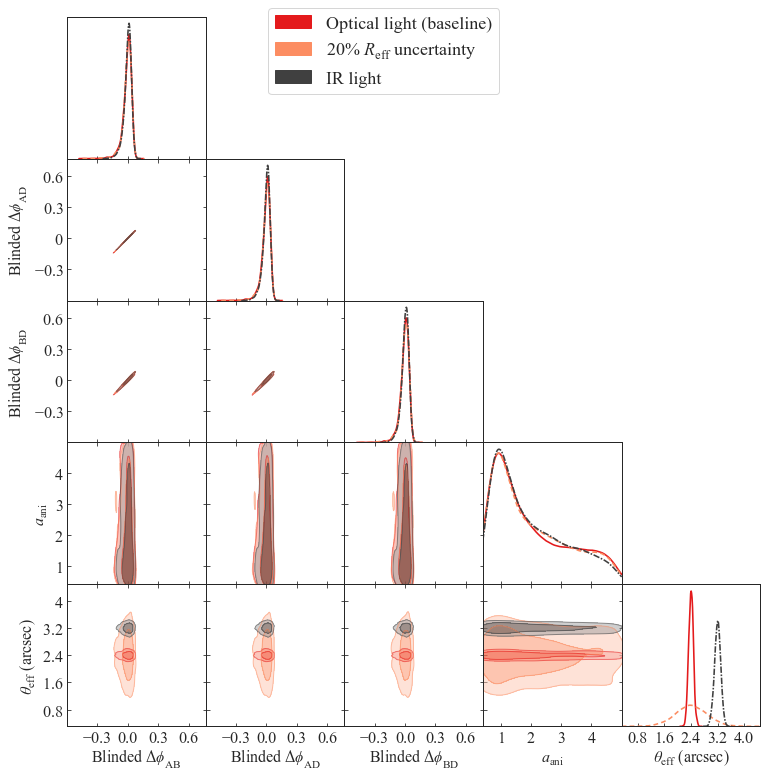

In [18]:
%matplotlib inline

## join powerlaw model samples
pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)

mc_samples = []
importance_sampled_samples_of_different_settings = []

for i, models in enumerate([powerlaw_models, powerlaw_models_optical_vel_dis, powerlaw_models_optical_vel_dis_20percent_reff]):
    all_pl_samples = np.array([])

    pl_kinematic_likelihoods = np.array([])

    for k, model in enumerate(models):

        num_sample = int(pl_weights[k] * model.get_num_samples())

        pl_samples = np.array([model.model_time_delays[:, 0] * (1. - model.kappa_ext),
                               model.model_time_delays[:, 1] * (1. - model.kappa_ext),
                               model.model_time_delays[:, 2] * (1. - model.kappa_ext),
                               model.a_ani,
                               model.r_eff
                            ])

        pl_kinematic_likelihoods = np.append(pl_kinematic_likelihoods, powerlaw_kinematics_likelihood[k][:num_sample])

        if k == 0:
            all_pl_samples = pl_samples[:, :num_sample]
        else:
            all_pl_samples = np.append(all_pl_samples, pl_samples[:, :num_sample], axis=1)

    importance_sampled_all_pl_indices = np.random.choice(np.arange(all_pl_samples.shape[1]),
                                                         size=int(all_pl_samples.shape[1]/10),
                                                         p=pl_kinematic_likelihoods/np.sum(pl_kinematic_likelihoods))
    importance_sampled_all_pl_samples = all_pl_samples[:, importance_sampled_all_pl_indices]
    
    if i == 0:
        mean_dphi_AB_lambda_int_1 = np.mean(importance_sampled_all_pl_samples[0])
        mean_dphi_AD_lambda_int_1 = np.mean(importance_sampled_all_pl_samples[1])
        mean_dphi_BD_lambda_int_1 = np.mean(importance_sampled_all_pl_samples[2])


    # blinding potential differences
    importance_sampled_all_pl_samples[0] = importance_sampled_all_pl_samples[0]/mean_dphi_AB_lambda_int_1 - 1.
    importance_sampled_all_pl_samples[1] = importance_sampled_all_pl_samples[1]/mean_dphi_AD_lambda_int_1 - 1.
    importance_sampled_all_pl_samples[2] = importance_sampled_all_pl_samples[2]/mean_dphi_BD_lambda_int_1 - 1.


    print('Power-law samples importance sampled: {}'.format(importance_sampled_all_pl_samples.shape))


    powerlaw_mc_samples= MCSamples(samples=importance_sampled_all_pl_samples.T, 
                                   names=[
                                          'dphi_AB', 'dphi_AD', 'dphi_BD', 'a_ani', 'r_eff',
                                         ], 
                                  labels=[
                                          '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                          '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                          '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm BD}', #'\\Delta \\phi^{\\rm eff}_{\\rm BD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm BD}} - 1',
                                          'a_{\\rm ani}',
                                          '\\theta_{\\rm eff}\\ {\\rm (arcsec)}',
                                         ],
                      )
    powerlaw_mc_samples.updateSettings({'smooth_scale_2D': 0.3})
    powerlaw_mc_samples.updateSettings({'smooth_scale_1D': 0.3})

    mc_samples.append(powerlaw_mc_samples)
    importance_sampled_samples_of_different_settings.append(importance_sampled_all_pl_samples)

# ## optical light profile in kinematic modeling
# all_pl_samples_optical_vel_dis = np.array([])
# pl_kinematic_likelihoods_optical_vel_dis = np.array([])

# for k, model in enumerate(powerlaw_models_optical_vel_dis):
    
#     num_sample = int(pl_weights[k] * model.get_num_samples())
    
#     pl_samples_optical_vel_dis = np.array([model.model_time_delays[:, 0] * (1. - model.kappa_ext),
#                            model.model_time_delays[:, 1] * (1. - model.kappa_ext),
#                            model.model_time_delays[:, 2] * (1. - model.kappa_ext),
#                            model.a_ani,
#                            model.r_eff
#                         ])
    
#     pl_kinematic_likelihoods_optical_vel_dis = np.append(pl_kinematic_likelihoods_optical_vel_dis, 
#                                                          powerlaw_kinematics_likelihood_optical_vel_dis[k][:num_sample])
    
#     if k == 0:
#         all_pl_samples_optical_vel_dis = pl_samples[:, :num_sample]
#     else:
#         all_pl_samples_optical_vel_dis = np.append(all_pl_samples_optical_vel_dis, 
#                                                    pl_samples_optical_vel_dis[:, :num_sample], axis=1)

# importance_sampled_all_pl_indices_optical_vel_dis = np.random.choice(np.arange(all_pl_samples_optical_vel_dis.shape[1]),
#                                                      size=int(all_pl_samples_optical_vel_dis.shape[1]/10),
#                                                      p=pl_kinematic_likelihoods_optical_vel_dis/np.sum(pl_kinematic_likelihoods_optical_vel_dis))
# importance_sampled_all_pl_samples_optical_vel_dis = all_pl_samples_optical_vel_dis[:, importance_sampled_all_pl_indices_optical_vel_dis]


# mean_dphi_AB_lambda_int_optical_vel_dis = np.mean(importance_sampled_all_pl_samples_optical_vel_dis[0])
# mean_dphi_AD_lambda_int_optical_vel_dis = np.mean(importance_sampled_all_pl_samples_optical_vel_dis[1])
# mean_dphi_BD_lambda_int_optical_vel_dis = np.mean(importance_sampled_all_pl_samples_optical_vel_dis[2])


# # blinding potential differences
# importance_sampled_all_pl_samples_optical_vel_dis[0] = importance_sampled_all_pl_samples_optical_vel_dis[0]/mean_dphi_AB_lambda_int_1 - 1.
# importance_sampled_all_pl_samples_optical_vel_dis[1] = importance_sampled_all_pl_samples_optical_vel_dis[1]/mean_dphi_AD_lambda_int_1 - 1.
# importance_sampled_all_pl_samples_optical_vel_dis[2] = importance_sampled_all_pl_samples_optical_vel_dis[2]/mean_dphi_BD_lambda_int_1 - 1.


# print('Power-law samples importance sampled: {}'.format(importance_sampled_all_pl_samples_optical_vel_dis.shape))


# powerlaw_mc_samples_optical_vel_dis = MCSamples(samples=importance_sampled_all_pl_samples_optical_vel_dis.T, 
#                                names=[
#                                       'dphi_AB', 'dphi_AD', 'dphi_BD', 'a_ani', 'r_eff',
#                                      ], 
#                               labels=[
#                                       '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
#                                       '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
#                                       '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm BD}', #'\\Delta \\phi^{\\rm eff}_{\\rm BD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm BD}} - 1',
#                                       'a_{\\rm ani}',
#                                       '\\theta_{\\rm eff}\\ {\\rm (arcsec)}',
#                                      ],
#                   )
# powerlaw_mc_samples_optical_vel_dis.updateSettings({'smooth_scale_2D': 0.3})
# powerlaw_mc_samples_optical_vel_dis.updateSettings({'smooth_scale_1D': 0.3})


# ## optical light profile in kinematic modeling

# all_pl_samples_optical_vel_dis_20percent_reff = np.array([])
# pl_kinematic_likelihoods_optical_vel_dis_20percent_reff = np.array([])

# for k, model in enumerate(powerlaw_models_optical_vel_dis_20percent_reff):
    
#     num_sample = int(pl_weights[k] * model.get_num_samples())
    
#     pl_samples_optical_vel_dis_20percent_reff = np.array([model.model_time_delays[:, 0] * (1. - model.kappa_ext),
#                            model.model_time_delays[:, 1] * (1. - model.kappa_ext),
#                            model.model_time_delays[:, 2] * (1. - model.kappa_ext),
#                            model.a_ani,
#                            model.r_eff
#                         ])
    
#     pl_kinematic_likelihoods_optical_vel_dis_20percent_reff = np.append(
#         pl_kinematic_likelihoods_optical_vel_dis_20percent_reff, 
#         powerlaw_kinematics_likelihood_optical_vel_dis_20percent_reff[k][:num_sample])
    
#     if k == 0:
#         all_pl_samples_optical_vel_dis_20percent_reff = pl_samples_optical_vel_dis_20percent_reff[:, :num_sample]
#     else:
#         all_pl_samples_optical_vel_dis_20percent_reff = np.append(all_pl_samples_optical_vel_dis_20percent_reff, 
#                                    pl_samples_optical_vel_dis_20percent_reff[:, :num_sample], axis=1)

# importance_sampled_all_pl_indices_optical_vel_dis_20percent_reff = np.random.choice(np.arange(all_pl_samples_optical_vel_dis_20percent_reff.shape[1]),
#                                                      size=int(all_pl_samples_optical_vel_dis_20percent_reff.shape[1]/10),
#                                                      p=pl_kinematic_likelihoods_optical_vel_dis_20percent_reff/np.sum(pl_kinematic_likelihoods_optical_vel_dis_20percent_reff))
# importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff = all_pl_samples_optical_vel_dis_20percent_reff[:, importance_sampled_all_pl_indices_optical_vel_dis_20percent_reff]


# mean_dphi_AB_lambda_int_optical_vel_dis_20percent_reff = np.mean(importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[0])
# mean_dphi_AD_lambda_int_optical_vel_dis_20percent_reff = np.mean(importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[1])
# mean_dphi_BD_lambda_int_optical_vel_dis_20percent_reff = np.mean(importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[2])


# # blinding potential differences
# importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[0] = importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[0]/mean_dphi_AB_lambda_int_1 - 1.
# importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[1] = importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[1]/mean_dphi_AD_lambda_int_1 - 1.
# importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[2] = importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff[2]/mean_dphi_BD_lambda_int_1 - 1.


# print('Power-law samples importance sampled: {}'.format(importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff.shape))


# powerlaw_mc_samples_optical_vel_dis_20percent_reff = MCSamples(
#     samples=importance_sampled_all_pl_samples_optical_vel_dis_20percent_reff.T, 
#                                names=[
#                                       'dphi_AB', 'dphi_AD', 'dphi_BD', 'a_ani', 'r_eff',
#                                      ], 
#                               labels=[
#                                       '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
#                                       '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
#                                       '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm BD}', #'\\Delta \\phi^{\\rm eff}_{\\rm BD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm BD}} - 1',
#                                       'a_{\\rm ani}',
#                                       '\\theta_{\\rm eff}\\ {\\rm (arcsec)}',
#                                      ],
#                   )
# powerlaw_mc_samples_optical_vel_dis_20percent_reff.updateSettings({'smooth_scale_2D': 0.3})
# powerlaw_mc_samples_optical_vel_dis_20percent_reff.updateSettings({'smooth_scale_1D': 0.3})


pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 16

g.settings.legend_fontsize = 18
# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4

colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([mc_samples[1], mc_samples[2], mc_samples[0]],
                 legend_labels=['Optical light (baseline)', r'20% $R_{\rm eff}$ uncertainty', 'IR light'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6, 1.6], 
                 contour_ls=['-', '--', '-.'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=[colors[0], pf.cb2_orange, pf.cb_grey],
                 param_limits={'dphi_AB': (-0.6, 0.7), 'dphi_AD': (-0.6, 0.7), 'dphi_BD': (-0.6, 0.7), 
                               'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.),},
                 #fontsize=100
               )

#g.fig.tight_layout()
if save_fig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/kinematics_systematic_compare_fixed_lambda_int.pdf', bbox_inches='tight')

In [19]:
settings = ['IR', 'Optical', 'F814W, 20% R_eff']

for j in range(3):
    print(settings[j])
    for i, pair in enumerate(['AB', 'AD', 'BD']):
        print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(importance_sampled_samples_of_different_settings[j][i, :])))


IR
	 Delta_phi_AB: 0.04
	 Delta_phi_AD: 0.04
	 Delta_phi_BD: 0.04
Optical
	 Delta_phi_AB: 0.05
	 Delta_phi_AD: 0.05
	 Delta_phi_BD: 0.05
F814W, 20% R_eff
	 Delta_phi_AB: 0.05
	 Delta_phi_AD: 0.05
	 Delta_phi_BD: 0.05



## Time-delay predictions with free $\lambda_{\rm int}$

In [20]:
model.model_velocity_dispersion.shape

(10000,)

In [21]:
def get_lambda_ints(model):
    """
    Get lambda_int distribution from model predicted velocity dispersion.
    """
    observed_velocity_dispersion = np.random.normal(loc=model.VEL_DIS[0], scale=model.SIG_VEL_DIS[0], 
                                                    size=model.get_num_samples()
                                                   )
    
    # c^2 x J function
    Jc2 = model.model_velocity_dispersion**2 / fiducial_Dsds 
    lambda_ints = observed_velocity_dispersion**2 / (Jc2 * np.random.choice(
                                                        pantheon_Dsds, 
                                                        size=model.get_num_samples())) / (1 - model.kappa_ext)
    
    return lambda_ints


lambda_ints_different_settings = []
lambda_ints = []
    
for models in [powerlaw_models, powerlaw_models_optical_vel_dis, powerlaw_models_optical_vel_dis_20percent_reff]:
    for model in models:                                               
        model.kappa_ext = draw_kappa_pl(n=model.model_velocity_dispersion.shape)
        lambda_ints.append(get_lambda_ints(model))
        
    lambda_ints_different_settings.append(lambda_ints)
    

## Plot

In [22]:
from getdist import plots
from getdist import MCSamples

In [23]:
powerlaw_bics = [model.bic for model in powerlaw_models]

In [24]:
# From the notebook "Fermat potentials and lens model comparisons"
sigma_numeric_bic, sigma_model_bic = 69, 304

-1.0
-1.0
-1.0
Power-law samples: (6, 39610)
Removed no burn in
-0.9998828814903075
-0.9998828288045252
-0.9998830844580605
Power-law samples: (6, 39654)
Removed no burn in
-0.9999011260345207
-0.9999010951729175
-0.9999012449263736
Power-law samples: (6, 39657)
Removed no burn in


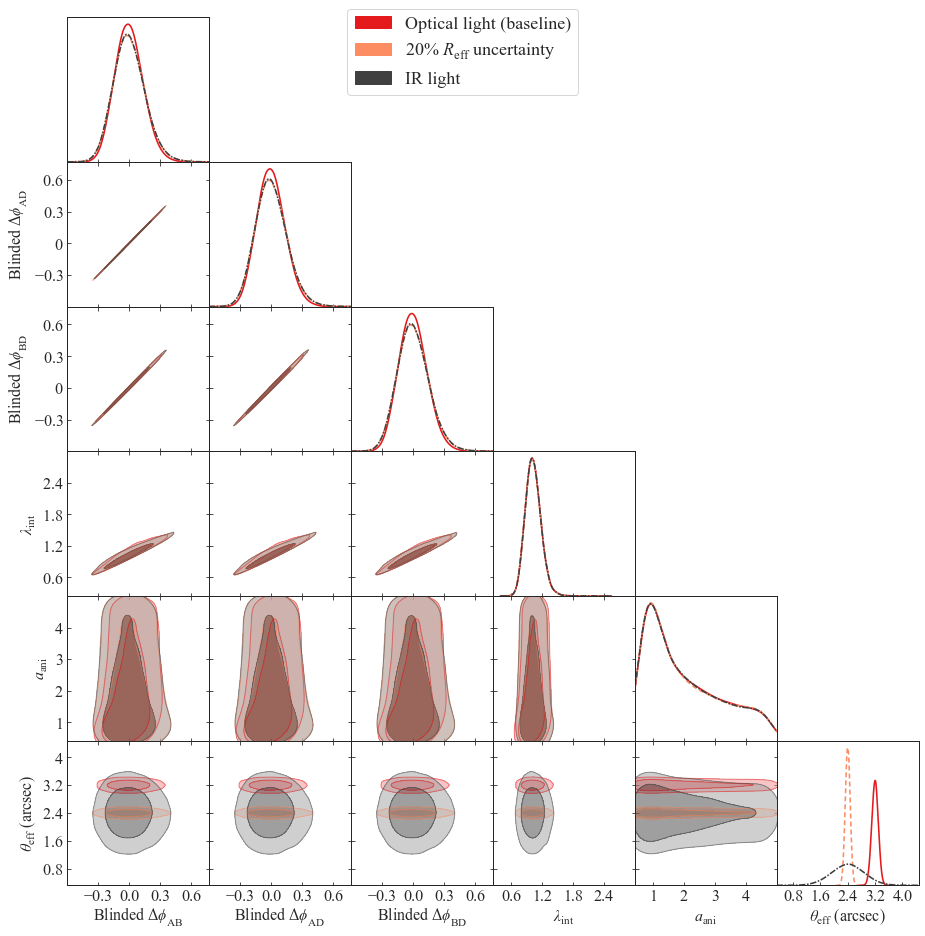

In [25]:
%matplotlib inline

mc_samples = []

for i, models in enumerate([powerlaw_models, powerlaw_models_optical_vel_dis, powerlaw_models_optical_vel_dis_20percent_reff]):
    powerlaw_lambda_ints = lambda_ints_different_settings[i]
    ## join powerlaw model samples
    pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                      sigma_model=sigma_model_bic)
    all_pl_samples = np.array([])

    for k, model in enumerate(models):

        num_sample = int(pl_weights[k] * model.get_num_samples())

        lambda_ints = powerlaw_lambda_ints[k]

        pl_samples = np.array([model.model_time_delays[:, 0] * (1. - model.kappa_ext) * lambda_ints,
                               model.model_time_delays[:, 1] * (1. - model.kappa_ext) * lambda_ints,
                               model.model_time_delays[:, 2] * (1. - model.kappa_ext) * lambda_ints,
                               lambda_ints,
                               model.a_ani,
                               model.r_eff
                            ])
        if k == 0:
            all_pl_samples = pl_samples[:, :num_sample]
        else:
            all_pl_samples = np.append(all_pl_samples, pl_samples[:, :num_sample], axis=1)

    
    if i == 0:
        mean_dphi_AB = np.mean(all_pl_samples[0])
        mean_dphi_AD = np.mean(all_pl_samples[1])
        mean_dphi_BD = np.mean(all_pl_samples[2])
    
    # blinding potential differences
    all_pl_samples[0] = all_pl_samples[0]/mean_dphi_AB - 1.
    all_pl_samples[1] = all_pl_samples[1]/mean_dphi_AD - 1.
    all_pl_samples[2] = all_pl_samples[2]/mean_dphi_BD - 1.

    
    for n in range(3):
        print(np.mean(all_pl_samples[n]/mean_dphi_AB - 1))
        
    print('Power-law samples: {}'.format(all_pl_samples.shape))


    powerlaw_mc_samples = MCSamples(samples=all_pl_samples.T, 
                                   names=[
                                          'dphi_AB', 'dphi_AD', 'dphi_BD', 'lambda_int', 'a_ani', 'r_eff',
                                         ], 
                                  labels=[
                                          '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                          '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                          '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm BD}', #'\\Delta \\phi^{\\rm eff}_{\\rm BD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm BD}} - 1',
                                          '\\lambda_{\\rm int}',
                                          'a_{\\rm ani}',
                                          '\\theta_{\\rm eff}\\ {\\rm (arcsec)}',
                                         ],
                      )
    powerlaw_mc_samples.updateSettings({'smooth_scale_2D': 0.3})
    powerlaw_mc_samples.updateSettings({'smooth_scale_1D': 0.3})
    
    
    mc_samples.append(powerlaw_mc_samples)
    
    

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 16

g.settings.legend_fontsize = 18
# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4

colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([mc_samples[0], mc_samples[1], mc_samples[2]],
                 legend_labels=['Optical light (baseline)', r'20% $R_{\rm eff}$ uncertainty', 'IR light'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6, 1.6], 
                 contour_ls=['-', '--', '-.'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=[colors[0], pf.cb2_orange, pf.cb_grey],
                 param_limits={'dphi_AB': (-0.6, 0.7), 'dphi_AD': (-0.6, 0.7), 'dphi_BD': (-0.6, 0.7), 
                               'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                 #fontsize=100
               )

#g.fig.tight_layout()
if save_fig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/kinematics_systematic_copare_free_lambda_int.pdf', bbox_inches='tight')